# 第2章 [実践] ニューラルネットワーク

このノートブックでは、第2章で説明した3層パーセプトロンによる手書き数字認識を再現します。

## 環境構築

このノートブックの内容をお手元のコンピュータ上で再現するために必要な環境は、以下のコマンドを実行することで構築できます。

    $ pip install -r requirements.txt

CUDA を使用できる場合は以下のコマンドも実行してください。

    $ pip install chainer_cuda_deps

## 準備

ノートブックの環境を準備します。

### matplotlib の設定

グラフが画像を表示するために使用する matplotlib の設定をします。

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

以下はグラフ用と画像の表示設定です。筆者の環境は Mac なので Osaka フォントを指定しています。

In [2]:
mpl.rcParams['font.family'] = [u'Osaka']
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### ライブラリのインポート

ノートブックで使用するライブラリをインポートします。

In [3]:
import sys
import numpy as np
import pandas as pd
from PIL import Image
import chainer
import chainer.functions as F
import chainer.optimizers
from chainer import cuda
import mnist

### GPU の設定

以下は、GPU が使えるかどうかを検査します。使える場合は `use_gpu` が `True` に設定されます。

In [4]:
gpu_device_id = 0
try:
    cuda.init(gpu_device_id)
    use_gpu = True
    print "GPU %d is available." % (gpu_device_id)
except:
    use_gpu = False
    print "GPU %d is not available." % (gpu_device_id)
    print "Error: ", sys.exc_info()[0], sys.exc_info()[1]

GPU 0 is available.


## MNIST データ

MNIST データをダウンロードし、それをロードして内容を確認します。

### データのダウンロード

データのダウンロードには付属のスクリプトを使用します。

In [5]:
!./download_mnist.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  74606      0  0:02:12  0:02:12 --:--:-- 54765
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0  21476      0  0:00:01  0:00:01 --:--:-- 21488
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  65852      0  0:00:25  0:00:25 --:--:--  338k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0   1629      0  0:00:02  0:00:02 --:--:--  1629


### データのロード

次に、データをロードします。

データをロードする処理は `mnist.py` に記載しています。興味がある方はそちらのスクリプトを参照してください。

In [6]:
# MNIST データをロード
mnist_data = mnist.load_data()

# MNIST 画像データは、8ビットのグレースケール画像である。
# これを、ピクセルの輝度が 0〜1 の浮動小数点数で表現される形式へ変換する。
images = mnist_data['images'].astype(np.float32)
images /= 255

# ラベルデータは整数として扱う
labels = mnist_data['labels'].astype(np.int32)

# images と labels は、訓練用データと検証用データを結合したもの。
# ここから、訓練用、検証用のそれぞれのデータを分離すr

train_count = mnist_data['train_count']  # 訓練用データの個数
test_count = mnist_data['test_count']    # 検証用データの個数

# 画像を訓練用 x_train と検証用 x_test に分離
x_train = images[0:train_count]
x_test  = images[train_count:]

# ラベルを訓練用 t_train と検証用 t_test に分離
t_train = labels[0:train_count]
t_test  = labels[train_count:]

### データの確認

`x_train` と `t_train` からデータをいくつか取り出して確認します。

[[5 0 4 1 9 2 1 3]
 [9 2 1 3 1 4 3 5]
 [1 4 3 5 3 6 1 7]
 [3 6 1 7 2 8 6 9]]


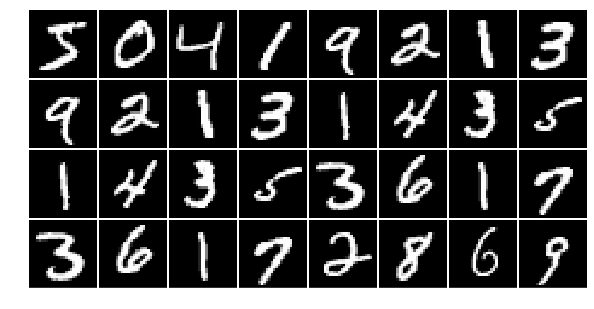

In [7]:
# MNIST 画像を並べて表示する関数
def display_mnist_random(ncols, nrows, pad=1):
    # 表示する画像数
    count = ncols * nrows

    # ランダムに count 個の画像を取り出すためのインデックス
    random_indices = np.random.permutation(train_count)[0:count]

    patch_width  = 28 # MNIST 画像の幅
    patch_height = 28 # MNIST 画像の高さ
    pad = 1 # 画像の間を1ピクセル空ける
    total_width = ncols * patch_width + pad * (ncols - 1)   # 全体の幅
    total_height = nrows * patch_height + pad * (nrows - 1) # 全体の高さ

    # MNIST 画像を配置するためのグレースケール画像を生成し、白 (255) で塗り潰す
    total_image = Image.new('L', (total_width, total_height), 255)
    
    # MNIST 画像に対応するラベルを集めるためのベクトル
    total_labels = np.ndarray((nrows, ncols), dtype=np.int64)

    # MNIST 画像を配置する
    for i in range(0, nrows):
        for j in range(0, ncols):
            index = i * nrows + j
            patch = x_train[index, :].reshape((patch_width, patch_height))
            subimage = Image.fromarray(patch * 255)
            total_image.paste(subimage, (j*(patch_width + pad), i*(patch_height + pad)))
            total_labels[i, j] = t_train[index]

    # 画像を表示する
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    plt.imshow(total_image, cmap=plt.cm.Greys_r, interpolation="none")
    plt.axis('off')

    # 画像と対応するラベルを表示する
    print(total_labels)

display_mnist_random(8, 4)

## ネットワーク構造の定義

In [8]:
model = chainer.FunctionSet(
    fc1=F.Linear(784, 64),  # 入力層から隠れ層への全結合
    fc2=F.Linear( 64, 10),  # 隠れ層から出力層への全結合
)

GPU が使える場合 (`use_gpu` が `True` の場合) は、ネットワークのパラメータを GPU 用に変換しておきます。

In [9]:
if use_gpu:
    model.to_gpu()

## 出力の計算

In [10]:
def forward(x):
    u2 = model.fc1(x)   # 入力層から隠れ層への結合
    z2 = F.relu(u2)     # 隠れ層の活性化関数
    u3 = model.fc2(z2)  # 隠れ層から出力層への結合
    return u3

def output(x):
    h = forward(x)
    return F.softmax(h)  # 出力層の活性化関数

def predict(x):
    y = output(x)                      # 確率ベクトル
    d = np.argmax(cuda.to_cpu(y.data)) # 予測数字
    return d

`predict` 関数内で使っている `cuda.to_cpu` は、引数で与えられたベクトルが GPU 用に変換されている場合に、それを CPU 用に戻す処理を行います。

## バックプロパゲーションによる学習

損失関数を定義します。

In [11]:
def loss(h, t):
    return F.softmax_cross_entropy(h, t)

最適化器を定義します。

In [12]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model.collect_parameters())

以下の `mini_batch_learn` 関数は、誌面に掲載したものに GPU 対応コードを入れ、正則化の強さを引数で指定できるようにしてあります。

In [13]:
# ミニバッチ方式による学習
# * x_train - 訓練用の入力データ
# * t_train - 訓練用の教師データ
# * mini_batch_size - ミニバッチのサイズ
# * wd - 正則化の強さ
def mini_batch_learn(x_train, t_train, mini_batch_size=10, wd=0.001):
    sum_loss = 0         # 全体の誤差を保持する変数
    sum_accuracy = 0     # 全体の正解率を保持する変数

    # データの無作為な並び換えを作成
    train_count = len(x_train)
    perm = np.random.permutation(train_count)

    # ミニバッチ単位で学習を進める
    for i in range(0, train_count, mini_batch_size):
        # ミニバッチを取り出す
        x_batch = x_train[perm[i:i + mini_batch_size]]
        t_batch = t_train[perm[i:i + mini_batch_size]]

        # GPU が使える場合はベクトルを GPU 用に変換する
        if use_gpu:
            x_batch = cuda.to_gpu(x_batch)
            t_batch = cuda.to_gpu(t_batch)

        optimizer.zero_grads()         # 勾配をゼロで初期化

        x = chainer.Variable(x_batch)  # 入力データ
        t = chainer.Variable(t_batch)  # 教師データ
        h = forward(x)
        e = loss(h, t)                 # 誤差を計算
        a = F.accuracy(h, t)           # 正解率を計算

        e.backward()                   # 誤差を逆伝搬
        optimizer.weight_decay(wd)     # 正則化
        optimizer.update()             # パラメータを更新

        # 全体の誤差と正解率に加算
        sum_loss     += float(cuda.to_cpu(e.data)) * len(t_batch)
        sum_accuracy += float(cuda.to_cpu(a.data)) * len(t_batch)

    # 誤差と正解率を返す
    train_loss     = sum_loss / train_count
    train_accuracy = sum_accuracy / train_count
    return train_loss, train_accuracy

## 学習結果の評価

以下の `mini_batch_test` 関数は誌面に掲載したものに、GPU 対応コードを入れています。

In [14]:
# ミニバッチ方式による評価
# * x_test - 評価用の入力データ
# * t_test - 評価用の教師データ
# * mini_batch_size - ミニバッチのサイズ
def mini_batch_test(x_test, t_test, mini_batch_size=10):
    sum_loss = 0         # 全体の誤差を保持する変数
    sum_accuracy = 0     # 全体の正解率を保持する変数

    test_count = len(x_test)
    for i in range(0, test_count, mini_batch_size):
        # ミニバッチを取り出す
        x_batch = x_test[i:i + mini_batch_size]
        t_batch = t_test[i:i + mini_batch_size]

        # GPU が使える場合はベクトルを GPU 用に変換する
        if use_gpu:
            x_batch = cuda.to_gpu(x_batch)
            t_batch = cuda.to_gpu(t_batch)

        x = chainer.Variable(x_batch)  # 入力データ
        t = chainer.Variable(t_batch)  # 教師データ
        h = forward(x)
        e = loss(h, t)                 # 誤差を計算
        a = F.accuracy(h, t)           # 正解率を計算

        # 全体の誤差と正解率に加算
        sum_loss     += float(cuda.to_cpu(e.data)) * len(t_batch)
        sum_accuracy += float(cuda.to_cpu(a.data)) * len(t_batch)

    # 誤差と正解率を返す
    test_loss     = sum_loss / test_count
    test_accuracy = sum_accuracy / test_count
    return test_loss, test_accuracy

## 学習、評価の繰り返しと結果の可視化

### 訓練の実行

ネットワークの訓練を実行します。時間がかかるため、途中経過を表の形で出力するようになっています。
この表は、変数 `data_normal` に記録される実行結果と同じものです。

In [15]:
# 誤差と正解率の記録用
data_normal = {
    'epoch': [],
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
}

max_epoch = 50  # 最大の学習回数

# 進捗ログのヘッダ
print("epoch\ttrain_loss\ttrain_accuracy\ttest_loss\ttest_accuracy")

for epoch in range(1, max_epoch + 1):
    data_normal['epoch'].append(epoch)

    # 訓練用データによる学習
    train_e, train_a = mini_batch_learn(x_train, t_train, mini_batch_size=50)
    data_normal['train_loss'].append(train_e)
    data_normal['train_accuracy'].append(train_a)

    # テスト用データによる評価
    test_e, test_a = mini_batch_test(x_test, t_test, mini_batch_size=50)
    data_normal['test_loss'].append(test_e)
    data_normal['test_accuracy'].append(test_a)

    # 進捗ログを出力
    print("{}\t{}\t{}\t{}\t{}".format(epoch, train_e, train_a, test_e, test_a))
    sys.stdout.flush()

epoch	train_loss	train_accuracy	test_loss	test_accuracy
1	0.359655061016	0.903966643897	0.224881760217	0.935099977553
2	0.191943332489	0.9463666448	0.165690085366	0.955299979448
3	0.153881382961	0.956816644271	0.134827750635	0.964099979997
4	0.132305102105	0.963666643649	0.130220859671	0.963199981749
5	0.119586570694	0.967249978185	0.116096135568	0.96549998194
6	0.111350437868	0.969783312033	0.112139235398	0.966199980974
7	0.105423816336	0.970833312174	0.109904114716	0.968799981475
8	0.100152748745	0.973349979271	0.10326864977	0.969899981022
9	0.0982701934145	0.973366645426	0.102664483009	0.971499982476
10	0.0950609500186	0.974683312724	0.0981472349435	0.971899981499
11	0.0937736817674	0.974733312478	0.0980173065176	0.971299982667
12	0.0918106202758	0.975683312515	0.113204626072	0.968699981272
13	0.0909998125102	0.975233312647	0.0953121963335	0.97329998225
14	0.0892766897194	0.976183312635	0.0978553123656	0.972799982131
15	0.0882546662213	0.976116645386	0.0963684241881	0.974399983883
1

### 結果の可視化

次に結果の可視化です。学習結果 `data_normal` を pandas のデータフレームに変換し、データフレームの機能を使ってグラフを描画します。

In [16]:
# 学習結果のデータフレームを作成
df_normal = pd.DataFrame(data_normal)

誤差の折れ線グラフを描きます。

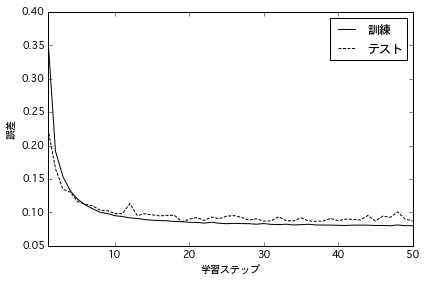

In [17]:
# 誤差の折れ線グラフ
fig = plt.figure()
ax = df_normal.plot(x='epoch', y='train_loss', style="k-")
df_normal.plot(x='epoch', y='test_loss', style="k--", dashes=(3, 1.5), ax=ax)
ax.set_xlabel(u'学習ステップ')
ax.set_ylabel(u'誤差')
ax.legend(labels=[u'訓練', u'テスト'])
plt.tight_layout()

正解率の折れ線グラフを描きます。

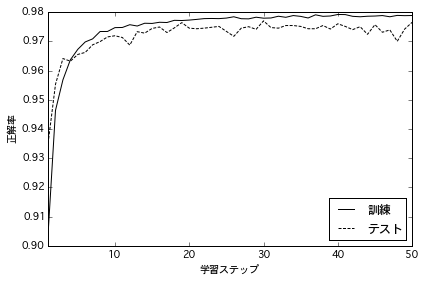

In [18]:
# 正解率の折れ線グラフ
fig = plt.figure()
ax = df_normal.plot(x='epoch', y='train_accuracy', style="k-")
df_normal.plot(x='epoch', y='test_accuracy', style="k--", dashes=(3, 1.5), ax=ax)
ax.set_xlabel(u'学習ステップ')
ax.set_ylabel(u'正解率')
ax.legend(labels=[u'訓練', u'テスト'], loc='lower right')
plt.tight_layout()

### 過学習する場合

正則化を弱めて過学習を起こしてみます。

In [19]:
# 後で可視化のため、学習済みのパラメータを保存
fc1_normal = model.fc1
fc2_normal = model.fc2

# 過学習を再現するためのモデルを初期化
model = chainer.FunctionSet(
    fc1=F.Linear(784, 64),  # 入力層から隠れ層への全結合
    fc2=F.Linear( 64, 10),  # 隠れ層から出力層への全結合
)

if use_gpu:
    model.to_gpu()

optimizer = chainer.optimizers.Adam()
optimizer.setup(model.collect_parameters())

# 誤差と正解率の記録用
data_overfit = {
    'epoch': [],
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
}
max_epoch = 50  # 最大の学習回数

# 進捗ログのヘッダ
print("epoch\ttrain_loss\ttrain_accuracy\ttest_loss\ttest_accuracy")

for epoch in range(1, max_epoch + 1):
    data_overfit['epoch'].append(epoch)

    # 訓練用データによる学習
    train_e, train_a = mini_batch_learn(x_train, t_train, mini_batch_size=50, wd=0.0001)
    data_overfit['train_loss'].append(train_e)
    data_overfit['train_accuracy'].append(train_a)

    # テスト用データによる評価
    test_e, test_a = mini_batch_test(x_test, t_test, mini_batch_size=50)
    data_overfit['test_loss'].append(test_e)
    data_overfit['test_accuracy'].append(test_a)

    # 進捗ログを出力
    print("{}\t{}\t{}\t{}\t{}".format(epoch, train_e, train_a, test_e, test_a))
    sys.stdout.flush()

epoch	train_loss	train_accuracy	test_loss	test_accuracy
1	0.343428140972	0.905466643547	0.194564190011	0.941299978793
2	0.169079585131	0.951416644255	0.145713470117	0.956599978805
3	0.125221656743	0.964449977527	0.114407486626	0.966299981773
4	0.0995551423371	0.971166645288	0.100288384082	0.970699985027
5	0.0824073036896	0.976616645604	0.0888286539604	0.973099982142
6	0.0708130922075	0.979033313493	0.0768014486926	0.975699984133
7	0.0618805315318	0.981983314306	0.0793604097835	0.97429998368
8	0.0553947909058	0.983683316062	0.0740876693874	0.975899981856
9	0.0500163263203	0.98533331578	0.0799005864194	0.975399983227
10	0.0458989543574	0.98651665017	0.0779694265859	0.975199982822
11	0.0420274807532	0.987683317463	0.0747612082324	0.976799982488
12	0.0385848575258	0.988833318849	0.07003085741	0.97649998337
13	0.0357989175025	0.989883319587	0.0710867349312	0.977099981904
14	0.0343326061325	0.990083318303	0.0694025605466	0.978099983633
15	0.0318878220455	0.990749986966	0.0733289850564	0.9766

In [20]:
# 学習結果のデータフレームを作成
df_overfit = pd.DataFrame(data_overfit)

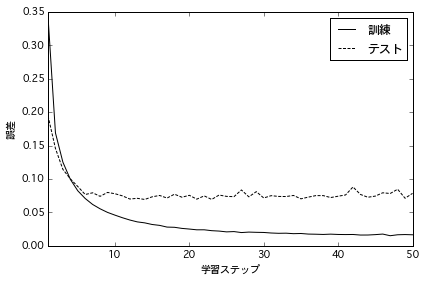

In [21]:
# 誤差の折れ線グラフ
fig = plt.figure()
ax = df_overfit.plot(x='epoch', y='train_loss', style="k-")
df_overfit.plot(x='epoch', y='test_loss', style="k--", dashes=(3, 1.5), ax=ax)
ax.set_xlabel(u'学習ステップ')
ax.set_ylabel(u'誤差')
ax.legend(labels=[u'訓練', u'テスト'])
plt.tight_layout()

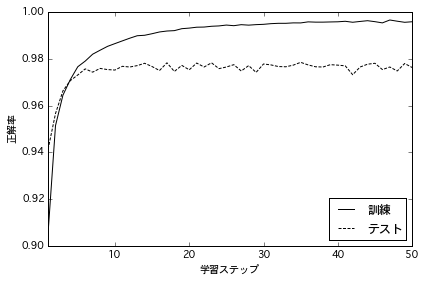

In [22]:
# 正解率の折れ線グラフ
fig = plt.figure()
ax = df_overfit.plot(x='epoch', y='train_accuracy', style="k-")
df_overfit.plot(x='epoch', y='test_accuracy', style="k--", dashes=(3, 1.5), ax=ax)
ax.set_xlabel(u'学習ステップ')
ax.set_ylabel(u'正解率')
ax.legend(labels=[u'訓練', u'テスト'], loc='lower right')
plt.tight_layout()

## 隠れ層と出力層の可視化

隠れ層と出力層は以下の関数で可視化します。

In [23]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def display_layer(weights, padsize=1, padval=0, shape=None):
    n = weights.shape[0]
    patch_width = weights.shape[1]
    patch_height = weights.shape[2]

    if shape != None:
        nrows = shape[0]
        ncols = shape[1]
    else:
        ncols = int(np.ceil(np.sqrt(n)))
        nrows = int(np.ceil(float(n) / ncols))

    image_width  = ncols * patch_width  + padsize*(ncols - 1)
    image_height = nrows * patch_height + padsize*(nrows - 1)

    image = Image.new('L', (image_width, image_height), padval*255)
    
    for i in range(0, nrows):
        for j in range(0, ncols):
            k = i * ncols + j
            if k < n:
                patch = weights[k, :].reshape((patch_width, patch_height))
                patch -= np.min(patch)
                patch /= np.max(patch)
                patch *= 255
                subimage = Image.fromarray(patch)
                image.paste(subimage, (j*(patch_width + padsize), i*(patch_height + padsize)))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(image)
    plt.axis('off')
    plt.tight_layout()

まずは、隠れ層です。

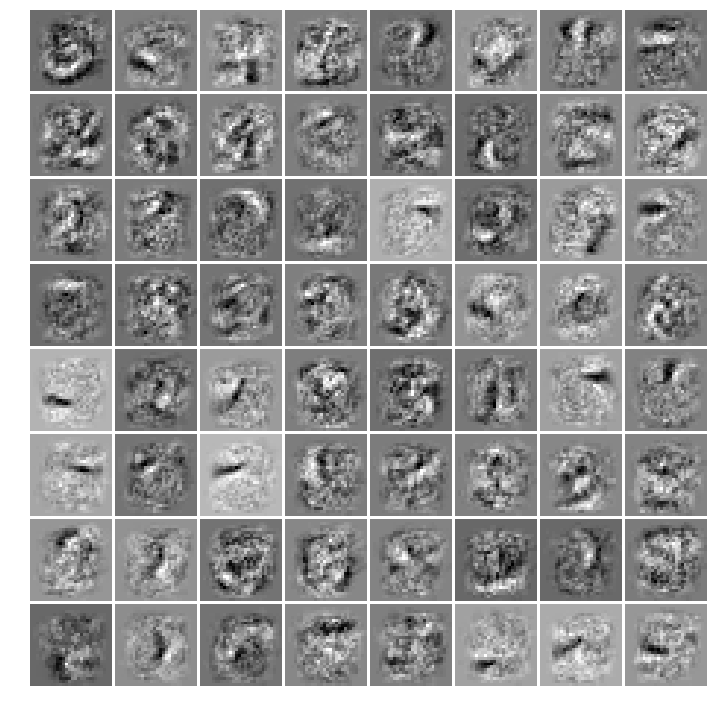

In [24]:
display_layer(cuda.to_cpu(model.fc1.W).reshape((64, 28, 28)), padval=1)

そして、隠れ層です。

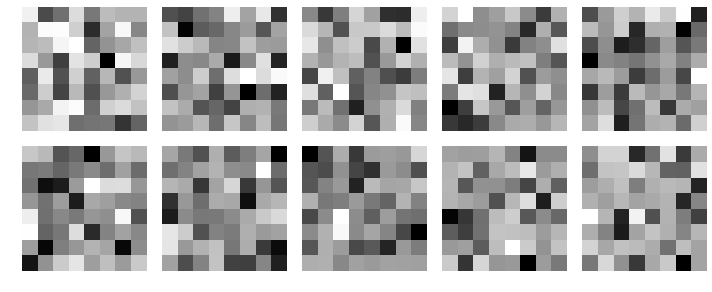

In [25]:
display_layer(cuda.to_cpu(model.fc2.W).reshape((10, 8, 8)), padval=1, shape=(2, 5))

## 隠れ層のニューロンが増減するとどうなるか

隠れ層のニューロン数の変化に対する、誤差と正解率と計算時間の変化を調べます。

In [26]:
import time

# 誤差と正解率の記録用
data_variable_size = {
    'hidden_size': [],
    'duration': [],
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
}

max_epoch = 50  # 最大の学習回数

for n in range(9, 2, -1):
    hidden_size = n*n
    data_variable_size['hidden_size'].append(hidden_size)

    model = chainer.FunctionSet(
        fc1=F.Linear(784, hidden_size),  # 入力層から隠れ層への全結合
        fc2=F.Linear(hidden_size,  10),  # 隠れ層から出力層への全結合
    )

    if use_gpu:
        model.to_gpu()

    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model.collect_parameters())

    # 進捗ログのヘッダ
    print("hidden_size\tepoch\ttrain_loss\ttrain_accuracy\ttest_loss\ttest_accuracy")
    sys.stdout.flush()

    # 実行時間を簡易的に計測するために開始時刻を記録
    started_at = time.time()

    for epoch in range(1, max_epoch + 1):
        # 訓練用データによる学習
        train_e, train_a = mini_batch_learn(x_train, t_train, mini_batch_size=100)

        # テスト用データによる評価
        test_e, test_a = mini_batch_test(x_test, t_test, mini_batch_size=100)

        # 進捗ログは毎 epoch について出力
        print("{:<11}\t{}\t{}\t{}\t{}\t{}".format(hidden_size, epoch, train_e, train_a, test_e, test_a))
        sys.stdout.flush()

    # 実行時間の簡易的な算出
    duration = time.time() - started_at
    print("duration = {}\n\n".format(duration))
    data_variable_size['duration'].append(duration)

    # 最終 epoch における誤差と正解率を記録
    data_variable_size['train_loss'].append(train_e)
    data_variable_size['train_accuracy'].append(train_a)
    data_variable_size['test_loss'].append(test_e)
    data_variable_size['test_accuracy'].append(test_a)

hidden_size	epoch	train_loss	train_accuracy	test_loss	test_accuracy
81         	1	0.396082543992	0.895033315606	0.227381410208	0.933999978304
81         	2	0.208653101288	0.941199982862	0.17692938583	0.949499976039
81         	3	0.168193971937	0.952966646651	0.143878735593	0.960399978161
81         	4	0.142676890461	0.960216643115	0.133691288373	0.962199978828
81         	5	0.128122086059	0.964716640611	0.123796265298	0.963599977493
81         	6	0.116906136256	0.967916638752	0.11299698289	0.968499978781
81         	7	0.109803729213	0.970299970806	0.107009004795	0.969999978542
81         	8	0.103776946592	0.972233303686	0.102107790792	0.971499976516
81         	9	0.0991652312595	0.973199968239	0.0985883197468	0.972299976349
81         	10	0.0965949409921	0.97446663479	0.105309006853	0.969899975061
81         	11	0.0936900063232	0.974599969685	0.0944286079402	0.974699975252
81         	12	0.0909616821166	0.975933303138	0.0948218138539	0.972399976254
81         	13	0.089171919357	0.97593

In [27]:
# 結果のデータフレームを作成
df_variable_size = pd.DataFrame(data_variable_size)
df_variable_size

,duration,hidden_size,test_accuracy,test_loss,train_accuracy,train_loss
0,142.791613,81,0.9771,0.083719,0.981117,0.074987
1,135.528563,64,0.9754,0.083252,0.980450,0.075686
2,133.285835,49,0.9742,0.097522,0.979067,0.079034
3,129.395678,36,0.9733,0.100244,0.976533,0.089373
4,119.104343,25,0.9693,0.110670,0.973617,0.099629
5,119.626076,16,0.9554,0.152625,0.959650,0.142874
6,118.987330,9,0.9299,0.241723,0.936317,0.228780


隠れ層のニューロン数に対する誤差の変化は以下のとおりです。

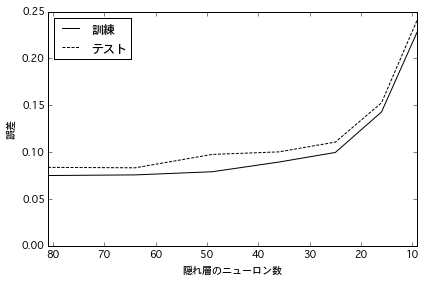

In [28]:
plt.figure()
ax = df_variable_size.plot(x="hidden_size", y="train_loss", style="k-")
df_variable_size.plot(x="hidden_size", y="test_loss", style="k--", dashes=(3, 1.5), ax=ax)
ax.set_xlabel(u'隠れ層のニューロン数')
ax.set_ylabel(u'誤差')
ax.legend(labels=[u'訓練', u'テスト'], loc=u'upper left')
plt.ylim(ymin=0)
plt.tight_layout()

隠れ層のニューロン数に対する正解率の変化は以下のとおりです。

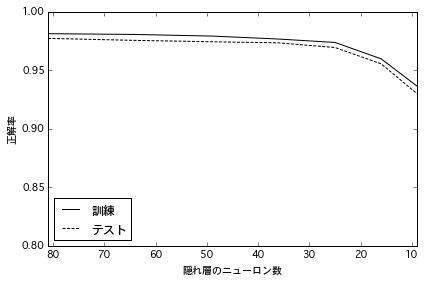

In [29]:
plt.figure()
ax = df_variable_size.plot(x="hidden_size", y="train_accuracy", style="k-")
df_variable_size.plot(x="hidden_size", y="test_accuracy", style="k--", dashes=(3, 1.5), ax=ax)
ax.set_xlabel(u'隠れ層のニューロン数')
ax.set_ylabel(u'正解率')
ax.legend(labels=[u'訓練', u'テスト'], loc=u'lower left')
plt.ylim(ymin=0.8, ymax=1)
plt.tight_layout()

隠れ層のニューロン数に対する計算時間の変化は以下のとおりです。

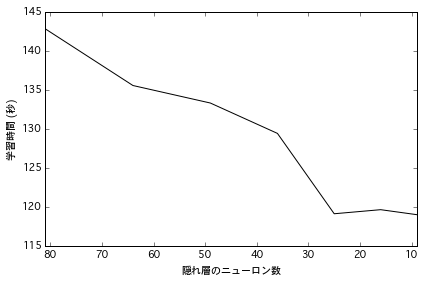

In [30]:
plt.figure()
ax = df_variable_size.plot(x="hidden_size", y="duration", style="k-", legend=False)
ax.set_xlabel(u'隠れ層のニューロン数')
ax.set_ylabel(u'学習時間 (秒)')
plt.tight_layout()

以上の結果は1回の実行で得られた計測値を示しています。同じ実験を何度も実行し、計測値の平均と標準偏差を求めると、もっと正確な傾向を把握できます。